In [16]:
#The following code has been adapted for the Finance industry from OpenAI examples
#
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import pandas as pd
import tiktoken
import openai
import numpy as np
import os
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

from urllib.parse import urlparse
from collections import deque
import os
from bs4 import BeautifulSoup
import requests



In [17]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]{0,1}://.+$'

# Define URL to crawl
domain = "www.flexlng.com"
full_urls = ["https://www.flexlng.com/flex-lng-fourth-quarter-2022-earnings-release/",
             "https://www.flexlng.com/flex-lng-third-quarter-2022-earnings-release/",
             "https://www.flexlng.com/flex-lng-second-quarter-2022-earnings-release/",
             "https://www.flexlng.com/flex-lng-first-quarter-2022-earnings-release/"]


In [18]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])


def crawl_single_page(url):
    local_domain = urlparse(url).netloc
    
    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # Ensure the directory exists
    directory = os.path.join('text', local_domain)
    os.makedirs(directory, exist_ok=True)

    # Create the file path using os.path.join()
    file_path = os.path.join(directory, url[8:].replace("/", "_") + ".txt")
    try:
        # Attempt to open the file
        # Save text from the url to a <url>.txt file
    
        with open(file_path, "w", encoding="UTF-8") as f:
            # Your code to write the content
            
            # Your code to write the content
            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)
    except Exception as e:
        print(f"Skipping file {file_path} due to an error: {e}")

for url in full_urls:
    crawl_single_page(url)

In [19]:


def remove_newlines(serie):
    
    serie = serie.str.replace('\n', ' ',regex=False)
    serie = serie.str.replace('\\n', ' ',regex=False)
    serie = serie.str.replace('  ', ' ',regex=False)
    serie = serie.str.replace('  ', ' ',regex=False)
    return serie


# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir(os.path.join("text", domain)):

    # Create the file path using os.path.join()
    file_path = os.path.join("text", domain, file)

    # Open the file and read the text
    with open(file_path, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-', ' ').replace('_', ' ').replace('#update', ''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()


,fname,text
0,.com flex lng first quarter 2022 earnings rele...,.com flex lng first quarter 2022 earnings rele...
1,.com flex lng fourth quarter 2022 earnings rel...,.com flex lng fourth quarter 2022 earnings rel...
2,.com flex lng second quarter 2022 earnings rel...,.com flex lng second quarter 2022 earnings rel...
3,.com flex lng third quarter 2022 earnings rele...,.com flex lng third quarter 2022 earnings rele...


<AxesSubplot: >

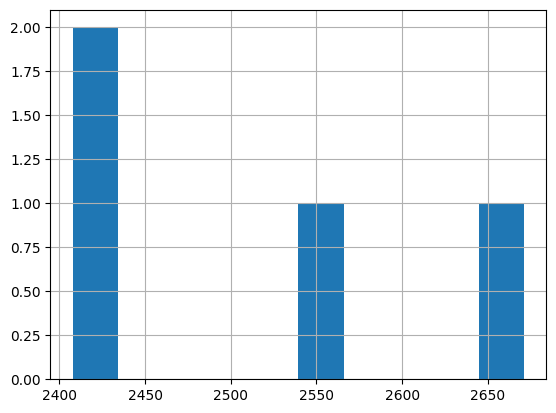

In [20]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()


In [21]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
        
    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

<AxesSubplot: >

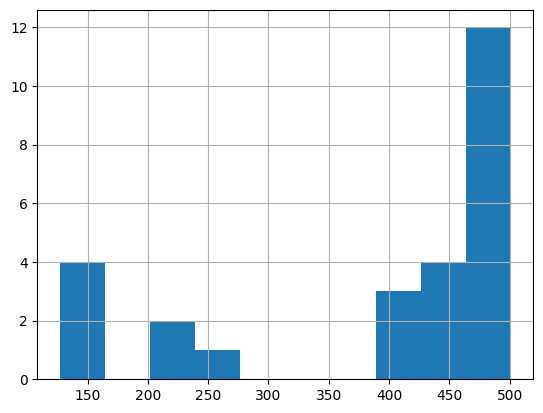

In [22]:
shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()


In [23]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()


,text,n_tokens,embeddings
0,.com flex lng first quarter 2022 earnings rele...,476,"[-0.009865384548902512, -0.012974112294614315,..."
1,"In April 2022, the Flex Ranger and Flex Rainbo...",474,"[-0.01068820245563984, -0.030453285202383995, ..."
2,We still have three ships which will be redeli...,492,"[-0.008680333383381367, -0.01668357290327549, ..."
3,The Private Securities Litigation Reform Act o...,432,"[-0.022875184193253517, -0.013425321318209171,..."
4,"In addition to these important factors, other ...",408,"[-0.005269658751785755, -0.02162148989737034, ..."


In [24]:

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()



,text,n_tokens,embeddings
0,.com flex lng first quarter 2022 earnings rele...,476,"[-0.009865384548902512, -0.012974112294614315,..."
1,"In April 2022, the Flex Ranger and Flex Rainbo...",474,"[-0.01068820245563984, -0.030453285202383995, ..."
2,We still have three ships which will be redeli...,492,"[-0.008680333383381367, -0.01668357290327549, ..."
3,The Private Securities Litigation Reform Act o...,432,"[-0.022875184193253517, -0.013425321318209171,..."
4,"In addition to these important factors, other ...",408,"[-0.005269658751785755, -0.02162148989737034, ..."


In [25]:

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)



In [26]:
def answer_question(
    df,
    model="text-davinci-003",
    question="What is FLNG dividend in 4Q?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=1500,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the questin and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""



In [28]:

print(answer_question(df, question="what was the difference between 3Q and 4Q earnings?", debug=False))
print(answer_question(df, question="what were the dividends from 1Q to 4Q? ", debug=False))
print(answer_question(df, question="How has the TCE rate changed from 1Q to 4Q ", debug=False))


The fourth quarter 2022 earnings had vessel operating revenues of $97.9 million, net income of $41.4 million and basic earnings per share of $0.78, compared to the third quarter 2022 earnings which had vessel operating revenues of $91.3 million, net income of $46.6 million and basic earnings per share of $0.88.
The dividends for 1Q to 4Q were $0.75 per share, $0.75 per share, $0.75 per share, and $1.00 per share, respectively, for a total of $3.75 per share declared for 2022.
The TCE rate increased from $70,707 per day for the second quarter 2022 to $75,941 per day for the third quarter 2022, and then increased again to $81,699 per day for the fourth quarter 2022.
